In [1]:
import os

import random

import pandas as pd
import numpy as np
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno

import sklearn
import sklearn.model_selection

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import KNNWithMeans, SVD
from surprise import accuracy

import pickle

#Settings
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

#To be avoided in your notebook.
import warnings
warnings.filterwarnings("ignore")

# 1. Exploratory Data Analysis

## Dataset Content

* **articles_metadata.csv** : CSV file with metadata information about all (364047) published articles
* **articles_embeddings.pickle** : Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the CHAMELEON's ACR module (see paper for details) for 364047 published articles.
* **clicks** : Folder with CSV files (one per hour), containing user sessions interactions in the news portal.
* **clicks_sample.csv** : CSV file containing user sessions interactions in the news portal.

In [4]:
[print(x) for x in os.listdir('news-portal-user-interactions-by-globocom')];

articles_embeddings.pickle
articles_metadata.csv
clicks
clicks_sample.csv


## 1.1 **articles_metadata.csv**

### Content

In [5]:
PATH_ARTICLES_DATA = "news-portal-user-interactions-by-globocom/articles_metadata.csv"
articles_df = pd.read_csv(PATH_ARTICLES_DATA)

In [6]:
articles_df.head(5)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


**articles_metadata.csv contain 5 columns :**
* **article_id :** ID of the article
* **category_id :** Category ID of the article
* **created_at_ts :** Date of creation (timestamp)
* **publisher_id :** ID of the publisher
* **words_count :** Total word contain in the article

### Missing Values

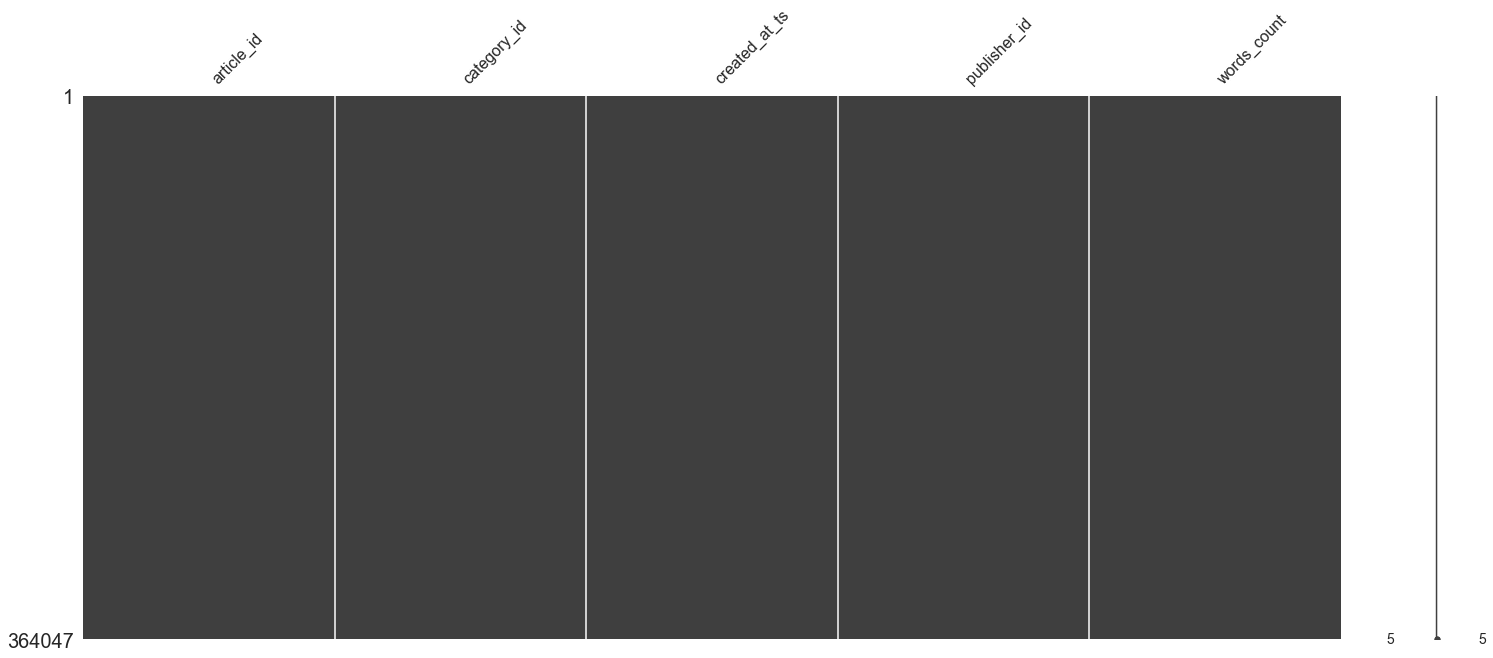

In [7]:
missingno.matrix(articles_df);

No value are missing.

In [8]:
articles_df['words_count'].describe()

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64

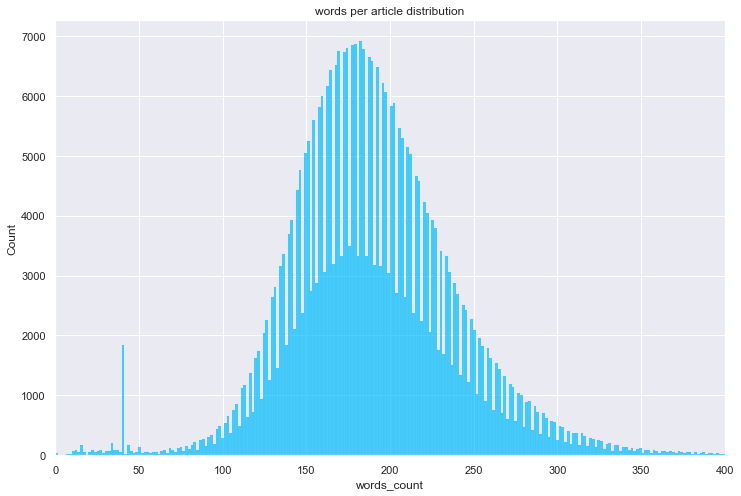

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['words_count'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.xlim([0,400])
plt.title('words per article distribution');
plt.show()

In [10]:
print(f'Empty article(s) : {articles_df[articles_df["words_count"] == 0].count()[0]}')

Empty article(s) : 35


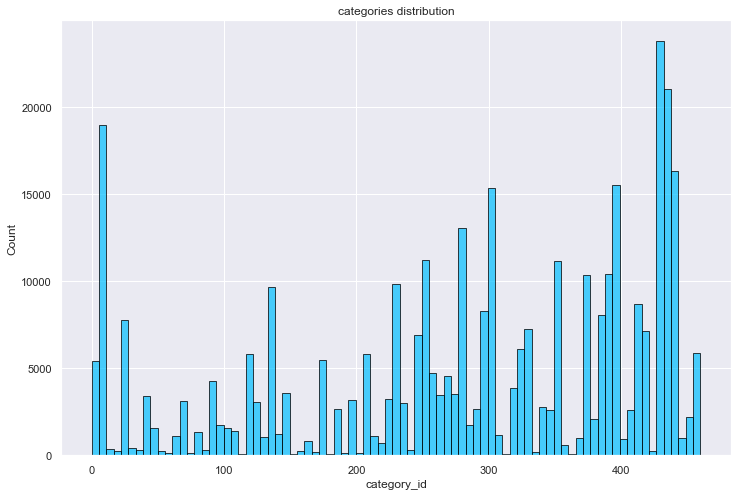

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['category_id'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.title('categories distribution');
plt.show()

## **1.2 clicks_{}.csv**

### Content

In [12]:
PATH_CLICK_SAMPLE_DATA = "news-portal-user-interactions-by-globocom/clicks_sample.csv"
clicks_samp_df = pd.read_csv(PATH_CLICK_SAMPLE_DATA)

In [13]:
clicks_samp_df.head(5)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [14]:
for session in clicks_samp_df.session_id:
    session_cliks = clicks_samp_df[clicks_samp_df.session_id == session]
    

<AxesSubplot:>

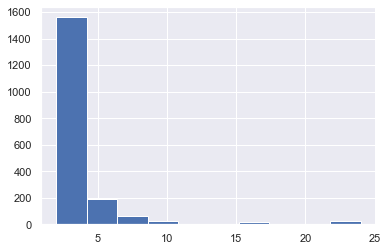

In [15]:
clicks_samp_df.session_size.hist()

In [47]:
clicks_samp_df.iloc[:-1].click_timestamp 

0       1506826828020
1       1506826858020
2       1506827017951
3       1506827047951
4       1506827090575
            ...      
1877    1506830999954
1878    1506830912301
1879    1506830942301
1880    1506829027334
1881    1506829095732
Name: click_timestamp, Length: 1882, dtype: int64

In [42]:
clicks_samp_df.iloc[:-1].click_timestamp

0       1506826828020
1       1506826858020
2       1506827017951
3       1506827047951
4       1506827090575
            ...      
1877    1506830999954
1878    1506830912301
1879    1506830942301
1880    1506829027334
1881    1506829095732
Name: click_timestamp, Length: 1882, dtype: int64

In [71]:
clicks_samp_df['time_read'] = np.append((clicks_samp_df.click_timestamp.values[1:] - clicks_samp_df.click_timestamp.values[:-1]),-1)
clicks_samp_df['not_last'] = np.append((clicks_samp_df.session_id.values[:-1] == clicks_samp_df.session_id.values[1:]), [False])

In [72]:
clicks_samp_df['last']

0        True
1       False
2        True
3       False
4        True
        ...  
1878     True
1879    False
1880     True
1881     True
1882     True
Name: last, Length: 1883, dtype: bool

In [73]:
clicks_samp_df[clicks_samp_df['not_last']]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,time_read,last,not_last
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,30000,True,True
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,30000,True,True
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,30000,True,True
6,3,1506825442704740,1506825442000,2,236065,1506827536942,4,3,2,1,21,1,30000,True,True
8,4,1506825528135741,1506825528000,2,48915,1506826927593,4,1,17,1,17,1,30000,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,704,1506828960113441,1506828960000,5,258386,1506830868850,4,1,17,8,28,1,101104,True,True
1876,704,1506828960113441,1506828960000,5,141517,1506830969954,4,1,17,8,28,1,30000,True,True
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2,30000,True,True
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1,68398,True,True


In [48]:
clicks_samp_df.iloc[:-1].click_timestamp - clicks_samp_df.iloc[1:].click_timestamp

0       NaN
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1878    0.0
1879    0.0
1880    0.0
1881    0.0
1882    NaN
Name: click_timestamp, Length: 1883, dtype: float64

In [13]:
[print(x) for x in clicks_samp_df.columns];

user_id
session_id
session_start
session_size
click_article_id
click_timestamp
click_environment
click_deviceGroup
click_os
click_country
click_region
click_referrer_type


**clicks_{}.csv contain 12 columns :**
* **user_id :** user ID
* **session_id :** Session ID
* **session_start :** Start of the session (timestamp)
* **session_size :** number of click/session
* **words_count :** Total word contain in the article
* **click_article_id :** article ID user clicked
* **click_timestamp :** When user clicked (timestamp)
* **click_environment :** user env when click
* **click_deviceGroup :** user device
* **click_os :** user OS
* **click_country :** localisation (country) when user clicked
* **click_region :** localisation (region) when user clicked
* **click_referrer_type :** ?

### Distribution
#### let's concat all clicks files and observe our datas

In [37]:
%%time

CLICK_FILES_PATH = "news-portal-user-interactions-by-globocom/clicks/"

#Get all .csv contain in clicks folder
click_files = [CLICK_FILES_PATH + x for x in os.listdir(CLICK_FILES_PATH)];

#Sort all files PATH contain in list.
click_files.sort()

#Check if all files are present.
print("Total PATH contain in list : ", len(click_files))

list_click_file_to_df = [pd.read_csv(x, index_col=None, header=0) for x in click_files];

#Remove unused columns
list_click_file_to_df_cleaned = [x.drop(columns = [#'session_id',
                                                   #'session_start',
                                                   'session_size',
                                                   #'click_timestamp',
                                                   'click_environment',
                                                   'click_deviceGroup',
                                                   'click_os',
                                                   'click_country',
                                                   'click_region',
                                                   'click_referrer_type']) for x in list_click_file_to_df]

all_clicks_df = pd.concat(list_click_file_to_df_cleaned, axis=0, ignore_index=True)

print(f"DataFrame shape : {all_clicks_df.shape}")

Total PATH contain in list :  385
DataFrame shape : (2988181, 5)
CPU times: total: 4.7 s
Wall time: 4.73 s


In [21]:
all_clicks_df

,user_id,session_id,session_start,click_article_id,click_timestamp
0,0,1506825423271737,1506825423000,157541,1506826828020
1,0,1506825423271737,1506825423000,68866,1506826858020
2,1,1506825426267738,1506825426000,235840,1506827017951
3,1,1506825426267738,1506825426000,96663,1506827047951
4,2,1506825435299739,1506825435000,119592,1506827090575
...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,84911,1508211557302
2988177,322896,1508211376302329,1508211376000,30760,1508211672520
2988178,322896,1508211376302329,1508211376000,157507,1508211702520
2988179,123718,1508211379189330,1508211379000,234481,1508211513583


In [ ]:
all

In [23]:
all_clicks_df['session_start'] = all_clicks_df.session_start//1000
all_clicks_df['click_timestamp'] = all_clicks_df.click_timestamp//1000
all_clicks_df['time_read'] = np.append((all_clicks_df.click_timestamp.values[1:] - all_clicks_df.click_timestamp.values[:-1]),-1)
all_clicks_df['not_last'] = np.append((all_clicks_df.session_id.values[:-1] == all_clicks_df.session_id.values[1:]), [False])

In [33]:
all_clicks_df['top'] = all_clicks_df.click_timestamp - all_clicks_df.session_start
all_clicks_df

,user_id,session_id,session_start,click_article_id,click_timestamp,time_read,not_last,top
0,0,1506825423271737,1506825423,157541,1506826828,30,True,1405
1,0,1506825423271737,1506825423,68866,1506826858,159,False,1435
2,1,1506825426267738,1506825426,235840,1506827017,30,True,1591
3,1,1506825426267738,1506825426,96663,1506827047,43,False,1621
4,2,1506825435299739,1506825435,119592,1506827090,30,True,1655
...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372,84911,1508211557,115,False,185
2988177,322896,1508211376302329,1508211376,30760,1508211672,30,True,296
2988178,322896,1508211376302329,1508211376,157507,1508211702,-189,False,326
2988179,123718,1508211379189330,1508211379,234481,1508211513,30,True,134


In [24]:
np.unique(all_clicks_df[all_clicks_df.not_last].time_read.values, return_counts=True)

(array([0, 1, 2, ..., 1006475, 1121327, 1212149], dtype=object),
 array([4931, 5618, 5049, ...,    1,    1,    1], dtype=int64))

In [25]:
all_clicks_df[all_clicks_df.not_last].groupby('time_read').count().sort_values('user_id', ascending=False)

,user_id,session_id,session_start,click_article_id,click_timestamp,not_last
time_read,,,,,,
30,1051613,1051613,1051613,1051613,1051613,1051613
1,5618,5618,5618,5618,5618,5618
4,5129,5129,5129,5129,5129,5129
2,5049,5049,5049,5049,5049,5049
5,4971,4971,4971,4971,4971,4971
...,...,...,...,...,...,...
15248,1,1,1,1,1,1
15239,1,1,1,1,1,1
15238,1,1,1,1,1,1


In [17]:
all_clicks_df.click_article_id.value_counts()

160974    37213
272143    28943
336221    23851
234698    23499
123909    23122
          ...  
3306          1
166713        1
214721        1
350088        1
98243         1
Name: click_article_id, Length: 46033, dtype: int64

In [18]:
all_clicks_df.click_article_id.value_counts()

160974    37213
272143    28943
336221    23851
234698    23499
123909    23122
          ...  
3306          1
166713        1
214721        1
350088        1
98243         1
Name: click_article_id, Length: 46033, dtype: int64

In [91]:
articles = all_clicks_df.click_article_id.value_counts().index
articles_df = articles_df.iloc[articles]

# 2. Build our Recommendation Models

**[Helpful link : build-recommendation-engine-collaborative-filtering](https://realpython.com/build-recommendation-engine-collaborative-filtering/)**

## 2.1 Data Preparation
For our recommendation model we need to find a scoring system to help the model understand the preferences of each user.

I decided to proceed like that : **Rating = Total_Click_Per_Cat_By_User / Total_Click_Done_By_User**

In [55]:
all_clicks_df['total_clicks_article'] = all_clicks_df.groupby(['click_article_id'])['user_id'].transform('count')
all_clicks_df['user_clicks_on_article'] = all_clicks_df.groupby(['user_id','click_article_id'])['click_article_id'].transform('count')
all_clicks_df['popularity_rating'] = all_clicks_df['user_clicks_on_article'] / all_clicks_df['total_clicks_article']

1.0

In [56]:
all_clicks_df = all_clicks_df.drop(['total_clicks_article', 'user_clicks_on_article'], axis=1)

In [104]:
#Create a map to convert article_id to category
dict_article_categories = articles_df.set_index('article_id')['category_id'].to_dict()

#Get Categorie associate for each article
all_clicks_df['category_id'] = all_clicks_df['click_article_id'].map(dict_article_categories).astype(int)
all_clicks_df['total_click'] = all_clicks_df.groupby(['user_id'])['click_article_id'].transform('count')
all_clicks_df['total_click_by_category_id'] = all_clicks_df.groupby(['user_id','category_id'])['click_article_id'].transform('count')
all_clicks_df['total_click_on_article_id'] = all_clicks_df.groupby(['user_id','click_article_id'])['click_article_id'].transform('count')
all_clicks_df['rating'] = all_clicks_df['total_click_by_category_id'] / all_clicks_df['total_click']

print(f'Shape before dropping duplicate : {all_clicks_df.shape}')
all_clicks_df = all_clicks_df.drop(['click_article_id'], axis=1)
all_clicks_df = all_clicks_df.drop_duplicates()
print(f'Shape after dropping duplicate : {all_clicks_df.shape}')

Shape before dropping duplicate : (2988181, 14)
Shape after dropping duplicate : (2988181, 14)


<AxesSubplot:>

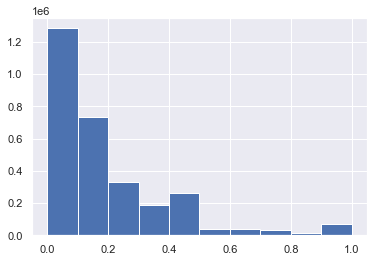

In [106]:
all_clicks_df.user_rating.hist()

In [61]:
#Remove not used columns
all_clicks_df = all_clicks_df.drop(['total_click', 'total_click_by_category_id'], axis=1)

all_clicks_df[all_clicks_df['user_id'] == 0]

,user_id,session_id,session_start,click_article_id,click_timestamp,popularity_rating,category_id,total_click_on_article_id,rating
0,0,1506825423271737,1506825423000,157541,1506826828020,0.002717,281,1,0.250
1,0,1506825423271737,1506825423000,68866,1506826858020,0.000667,136,1,0.125
1287361,0,1507340000920377,1507340000000,96755,1507340033155,0.000168,209,1,0.125
1287362,0,1507340000920377,1507340000000,313996,1507340063155,0.000256,431,1,0.125
1352197,0,1507385847186982,1507385847000,160158,1507388090915,0.000536,281,1,0.250
1352198,0,1507385847186982,1507385847000,233470,1507388120915,0.001379,375,1,0.125
1535240,0,1507514030209212,1507514030000,87224,1507514056617,0.000205,186,1,0.250
1535241,0,1507514030209212,1507514030000,87205,1507514086617,0.000744,186,1,0.250


In [60]:
all_clicks_df.rating.max()

1.0

<AxesSubplot:>

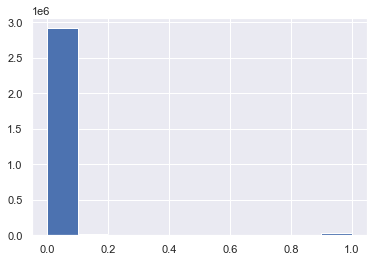

In [102]:
all_clicks_df.popularity_rating.hist()

<AxesSubplot:>

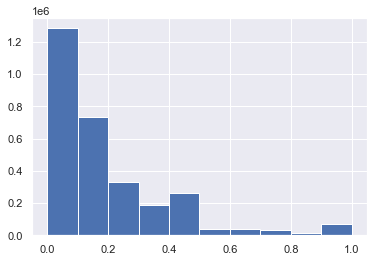

In [62]:
all_clicks_df.rating.hist()

<AxesSubplot:>

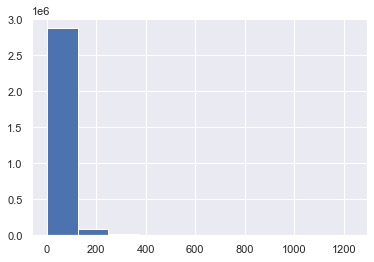

In [59]:
all_clicks_df.total_click.hist()

In [69]:
scipy.stats.hmean(all_clicks_df[['rating', 'popularity_rating']], axis=1)

array([0.00537634, 0.00132626, 0.00227015, ..., 0.04      , 0.00320641,
       0.05298013])

<AxesSubplot:>

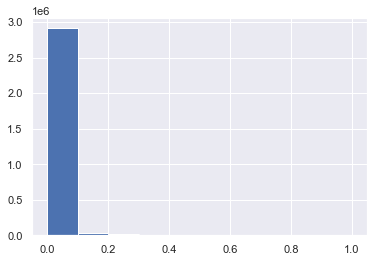

In [72]:
import scipy
all_clicks_df['hmean_rating'] = scipy.stats.hmean(all_clicks_df[['rating', 'popularity_rating']], axis=1)
all_clicks_df['hmean_rating'].hist()

<AxesSubplot:>

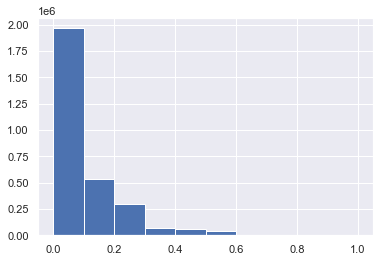

In [73]:
all_clicks_df['mean_rating'] = all_clicks_df[['rating', 'popularity_rating']].mean(axis=1)
all_clicks_df['mean_rating'].hist()

We don't need Total_click and total_click_by_category_id anymore.

In [74]:
#keep ~42 000 users to build our model.
df = all_clicks_df[all_clicks_df['user_id'] < 42000]
print(f'size of our sample : {df.shape}')

size of our sample : (770610, 11)


In [75]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

#Split our Dataframe 75% train / 25% test
data = Dataset.load_from_df(df[['user_id', 'category_id', 'mean_rating']], reader)
train_set, test_set = train_test_split(data, test_size=.25)
print(f'Size of test set : {len(test_set)}')

Size of test set : 192653


## 2.2 SVD (baseline)
### 2.3.1 Train Model

In [76]:
%%time

model = SVD().fit(train_set)

CPU times: total: 5.95 s
Wall time: 5.95 s


### 2.3.2 Results

In [79]:
predict = model.test(test_set)

#Print our Results
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);

print(f'Prediction rating for User 0 with cat 281 : {model.predict(0, 281).est}')
print(f'Current rating : {df[(df["user_id"] == 0) & (df["category_id"] == 281)]["rating"].values}')

RMSE: 0.1192
MSE: 0.0142
MAE:  0.0997
Prediction rating for User 0 with cat 281 : 0.29516472032903046
Current rating : [0.25 0.25]


### 2.3.3 Predictions with test set

In [80]:
#Function from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [81]:
top_n = get_top_n(predict, n=10)

In [82]:
recommanded_cat = [iid for iid, _ in top_n[1]]
print(recommanded_cat)
np.random.choice(np.hstack([articles_df[articles_df['category_id'] == x]['article_id'].values for x in recommanded_cat]), 5)

[281, 281, 375, 375]


array([232092, 162269, 234229, 159030, 231100], dtype=int64)

In [83]:
#Make simple recommendation for user.
def make_recommendation(user_ID, top_n, df_rating, articles_df):
    """Return a list of recommanded articles based on the taste of the user and all recommended categories
    Args:
        user_id -> user id used for recommendation
        top_n -> top-N recommendation for each user from a set of predictions
        df_rating -> df used to train our algo
        articles_df -> df with metadata of all articles.
    Returns:
        list(recommanded articles), list(recommanded categories)
    """
    #Get top 5 cat and adding it to our list
    recommanded_cat = [iid for iid, _ in top_n[user_ID]]
    
    '''#If we don't have any recommandation, use our data.
    if not recommanded_cat:
        recommanded_cat = df_rating[df_rating['user_id'] == user_ID].nlargest(1, ['rating'])['category_id'].values'''
    
    #Select 5 randoms articles from all the articles in the recommanded categegories.
    recommanded_articles = np.random.choice(np.hstack([articles_df[articles_df['category_id'] == x]['article_id'].values for x in recommanded_cat]), 5)

    
    return recommanded_articles, recommanded_cat

In [84]:
recommendation, categories = make_recommendation(1, top_n, df, articles_df)
print(f'recommanded categories for user_id[1] : {categories}')
print(f'recommanded articles for user_id[1] : {recommendation}')

recommanded categories for user_id[1] : [281, 281, 375, 375]
recommanded articles for user_id[1] : [235998 152392 159315 235101 229914]


## 2.3 KNNWithMeans (Collaborative model)
### 2.3.1 Train Model

In [85]:
%%time 

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute similarities between items
}

model = KNNWithMeans(sim_options=sim_options).fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: total: 1.92 s
Wall time: 1.93 s


### 2.3.2 Results

In [86]:
predict = model.test(test_set)

#Print our Results
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);

RMSE: 0.0595
MSE: 0.0035
MAE:  0.0337


pretty good ! now let's see if our model will predictions will be different from SVD

In [87]:
print(f'Prediction rating for User 0 with cat 281 : {model.predict(0, 281).est}')
print(f'Current rating : {df[(df["user_id"] == 0) & (df["category_id"] == 281)]["rating"].values}')

Prediction rating for User 0 with cat 281 : 0.14662937762123407
Current rating : [0.25 0.25]


### 2.3.3 Prediction with testSet

In [88]:
top_n = get_top_n(predict, n=10)

In [89]:
recommendation, categories = make_recommendation(3, top_n, df, articles_df)

print(f'recommanded categories for user_id[0] : {categories}')
print(f'recommanded articles for user_id[0] : {recommendation}')

recommanded categories for user_id[0] : [375, 375, 375, 375, 421]
recommanded articles for user_id[0] : [229629 228918 229683 233966 230090]


## 2.4 Content-Based Prediction
Simple content-based prediction.

[towardsdatascience article that helped me](https://towardsdatascience.com/recommender-system-in-python-part-1-preparation-and-analysis-d6bb7939091e)

### 2.4.1 Using word embedding

In [93]:
pickle = pd.read_pickle('news-portal-user-interactions-by-globocom/articles_embeddings.pickle')
pickle = pickle[articles]
pickle.shape

(46033, 250)

In [94]:
articles_df

,article_id,category_id,created_at_ts,publisher_id,words_count
160974,160974,281,1506912747000,0,259
272143,272143,399,1506961870000,0,184
336221,336221,437,1507613161000,0,158
234698,234698,375,1507618597000,0,183
123909,123909,250,1507198955000,0,240
...,...,...,...,...,...
3306,3306,1,1505861726000,0,164
166713,166713,290,1431842611000,0,197
214721,214721,348,1496820319000,0,282
350088,350088,442,1451470418000,0,182


In [95]:
%%time

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities  = cosine_similarity(pickle, pickle)

CPU times: total: 38.3 s
Wall time: 22.5 s


In [96]:
articles_df = articles_df.reset_index()

In [97]:
from tqdm.notebook import  tqdm
results = {}
for idx, row in tqdm(articles_df.iterrows()):
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1] 
    similar_items = [(cosine_similarities[idx][i], articles_df['article_id'][i]) for i in similar_indices] 
    results[row['article_id']] = similar_items[1:]

0it [00:00, ?it/s]

In [99]:
articles_df

,index,article_id,category_id,created_at_ts,publisher_id,words_count
0,160974,160974,281,1506912747000,0,259
1,272143,272143,399,1506961870000,0,184
2,336221,336221,437,1507613161000,0,158
3,234698,234698,375,1507618597000,0,183
4,123909,123909,250,1507198955000,0,240
...,...,...,...,...,...,...
46028,3306,3306,1,1505861726000,0,164
46029,166713,166713,290,1431842611000,0,197
46030,214721,214721,348,1496820319000,0,282
46031,350088,350088,442,1451470418000,0,182


In [101]:
def recommend(item_id, num):
    print("Recommending " + str(num) + " products similar to " + str(item_id) + "...")   
    print("-------")
    recs = results[item_id][:num]   
    print(recs)
        
recommend(160974, 5)

Recommending 5 products similar to 160974...
-------
[(0.89519405, 156560), (0.8683922, 161100), (0.8603612, 159764), (0.8603498, 162765), (0.85822546, 159034)]


In [ ]:
def recommend_user(user_id, num):
    

### 2.4.1 Content-based

In [52]:
df_cb = df.copy()

#Add number total of rating for each
num_ratings = pd.DataFrame(df_cb.groupby('category_id').count()['rating']).reset_index()
df_cb = pd.merge(left=df_cb, right=num_ratings, on='category_id')
df_cb.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)

In [53]:
#Category_id
def get_similar_category(category_id, df, n_ratings_filter=50, n_recommendations=5):
    matrix = df.pivot_table(
        index='user_id',
        columns='category_id',
        values='rating'
    )
    
    similar = matrix.corrwith(matrix[category_id])
    corr_similar = pd.DataFrame(similar, columns=['correlation'])
    corr_similar.dropna(inplace=True)
    
    orig = df.copy()
    
    corr_with_category = pd.merge(
        left=corr_similar, 
        right=orig,
        on='category_id')[['category_id', 'correlation', 'numRatings']].drop_duplicates().reset_index(drop=True)
    
    result = corr_with_category[corr_with_category['numRatings'] > n_ratings_filter].sort_values(by='correlation', ascending=False)
    
    result = result[result['category_id'] != category_id]
    return result.head(n_recommendations)

In [60]:
result = get_similar_category(412, df_cb)

#Top 5 corr categories with category_id = 1
result.head(5)

,category_id,correlation,numRatings
38,123,0.854137,5382
107,285,0.820774,1010
159,396,0.794898,1217
131,339,0.782811,824
138,353,0.716940,3297


### 2.4.2 Evaluation

In [55]:
train, test = sklearn.model_selection.train_test_split(df_cb, test_size=0.3, random_state=42, shuffle=True)

In [56]:
%%time

all_categories = train['category_id'].unique()
predictions = {}

for val in all_categories:
    predictions[val] = get_similar_category(val, train)

CPU times: total: 2min 59s
Wall time: 3min


In [34]:
train[train['user_id'] == 2]

,user_id,category_id,rating,numRatings
418918,2,332,0.25,2769


In [35]:
predictions[332]

,category_id,correlation,numRatings
125,402,1.000000,62
81,295,0.998921,74
54,211,0.996745,54
74,271,0.994981,53
46,184,0.992412,79


In [36]:
test[test['user_id'] == 2]

,user_id,category_id,rating,numRatings
71148,2,247,0.25,10563
81711,2,26,0.50,7542


after a few tries with different users i realize that the lack of information does not allow me to use this method in an efficient way...

# 3. Select best model and deployment

In [114]:
%%time

# Retrieve the trainset.
train_set = data.build_full_trainset()

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute similarities between items
}

model = KNNWithMeans(sim_options=sim_options).fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: total: 1.38 s
Wall time: 1.38 s


In [57]:
def predict_best_category_for_user(user_id, model, article_df):
    predictions = {}
    
    #Category 1 to 460
    for i in range(1, 460):
        _, cat_id, _, est, err = model.predict(user_id, i)
        
        #Keep prediction only if we could keep it.
        if (err != True):
            predictions[cat_id] = est
    
    best_cats_to_recommend = dict(sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:5])
    
    recommended_articles = []
    for key, _ in best_cats_to_recommend.items():
        recommended_articles.append(int(articles_df[articles_df['category_id'] == key]['article_id'].sample(1).values))
    
    #return random_articles_for_best_cat, best_cat_to_recommend
    return recommended_articles, best_cats_to_recommend

In [58]:
results, recommended_cats = predict_best_category_for_user(1, model, articles_df)

print(f'Reco cat : {recommended_cats}')
print(f'5 randoms articles from cat {results}')

Reco cat : {22: 0.5, 202: 0.5, 62: 0.33164799195228956, 240: 0.3070882376685252, 287: 0.2581979853659435}
5 randoms articles from cat [24993, 91200, 38897, 115224, 164362]


In [59]:
# Save to file in the current working directory
pkl_filename = "pickle_surprise_model_KNNWithMeans.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [41]:
results, recommended_cats = predict_best_category_for_user(1, pickle_model, articles_df)

print(f'Reco cat : {recommended_cats}')
print(f'5 randoms articles from cat {results}')

Reco cat : {22: 0.5, 70: 0.5, 159: 0.5, 370: 0.5, 62: 0.311823069331905}
5 randoms articles from cat [24998, 43050, 78546, 227592, 38878]
